# Идеи

1. Эмбеддинги самари и коментарии                              +++
2. Часовые пояса у пользователей
3. Порядковые номера тасков внутри проекта                     +++
4. Количество одновременно назначенных тасков у пользователя
5. Количество комментариев у таска                             +++
6. Почистить комментарии от автоматического текста
7. Отдельные фичи для слов из долгих тасков(коммуникация, тестинг и тп.). Чистка, лемматизация, подсчет частотности в тасках 100 000+

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import pymorphy2
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from collections import Counter
import lightgbm

from transformers import AutoTokenizer, AutoModel
from umap.umap_ import UMAP
import torch
import nltk
from tqdm import tqdm
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
TOKENIZER = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
BERT = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
MORPH = pymorphy2.MorphAnalyzer()


Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [290]:
df_issues_train = pd.read_csv("data/train_issues.csv")
df_comment_train = pd.read_csv("data/train_comments.csv")

df_issues_test = pd.read_csv("data/test_issues.csv")
df_comment_test = pd.read_csv("data/test_comments.csv")

df_emp = pd.read_csv("data/employees.csv")

In [291]:
df_issues_test['overall_worklogs'] = -1
df_all = pd.concat([df_issues_train, df_issues_test]).reset_index(drop=True)
df_all_com = pd.concat([df_comment_train, df_comment_test]).reset_index(drop=True)
df_all_com.text = df_all_com.text.apply(lambda x: x.split(':')[-1] if x.__contains__('mentioned this issue in') else x)

In [235]:
test = df_all[:20].copy()

### Предобработка

In [292]:
# ОБЪЕДИНЕНИЕ ВСЕХ ТЕКСТОВЫХ ДАННЫХ
def concat_all_text(X):    
    com_df = pd.merge(X, df_all_com, left_on="id", right_on="issue_id", how='left')
    com_df.text = com_df.text.fillna('')
    all_text = {}
    for val in X.id:
        all_text[val] = com_df[com_df.id == val].summary.iloc[0]
        all_text[val] += ' '.join([text for text in com_df[com_df.id == val].text.values])
    X['all_text'] = all_text.values()
    
# ДАТА И ВРЕМЯ
def encode_date(X):
    X.created = pd.to_datetime(X.created)
    X['day'] = X.created.dt.strftime('%d').astype(int)
    X['month'] = X.created.dt.strftime('%m').astype(int)
    X['hour'] = X.created.dt.strftime("%H").astype(int)
    X['day_of_week'] = X.created.dt.strftime("%w").astype(int)
    X.drop('created', axis=1, inplace=True)

# КОЛИЧЕСТВО И ДЛИНА КОММЕНТАРИЕВ
def process_coments(X):
    com_df = pd.DataFrame(pd.merge(X, df_all_com, left_on="id", right_on="issue_id", how='left'))
    com_df.text = com_df.text.astype('str')
    com_df.text = com_df.text.apply(len).astype('int')
    counts = com_df.groupby('id').comment_id.count()
    lens = com_df.groupby('id').text.sum()
    X['comments_count'] = pd.merge(X, counts, left_on='id', right_index=True).comment_id
    X['comments_len'] = pd.merge(X, lens, left_on='id', right_index=True).text
    
# ИНФОРМАЦИЯ ОБ ИСПОЛНИТЕЛЕ
def get_assignee_info(X):
    df = pd.merge(X, df_emp, left_on='assignee_id', right_on='id', how='left')
    df.fillna('unknown', inplace=True)
    col_list = ['position', 'hiring_type', 'payment_type', 'passport', 'is_nda_signed', 'is_labor_contract_signed', 'is_added_to_internal_chats', 'is_added_one_to_one']
    X[col_list] = df[col_list]

# СТАТИСТИКИ СОТРУДНИКОВ
def get_stats(X, field):
    train_df = X[X.overall_worklogs != -1]
    stats_df = train_df.groupby(field).agg({'overall_worklogs': [min, max, np.mean, np.median, np.std]})
    stats_df.columns = [f'{field.split("_")[0]}_{i}_time' for i in stats_df.columns.droplevel(0)]
    X[stats_df.columns] = pd.merge(X, stats_df, left_on=field, right_index=True, how='left')[stats_df.columns]
    
# TF-IDF UMAP
def preprocess(text: str) -> list:
    tokenized = nltk.word_tokenize(text.lower())
    normalized = [MORPH.parse(word)[0].normal_form for word in tokenized
                  if len(word) > 1 and word.isalpha()]
    return normalized

def tf_idf(freqs):
    return (freqs / (freqs.sum(axis=1) + 0.0001)[:, np.newaxis] ) * np.log(freqs.shape[0] / ((freqs >= 1).sum(axis=0) + 1))

def mess_to_vec(vocab: dict, message: list):
    vec = np.zeros(len(vocab) + 1)
    for token in message:
        if token in vocab:
            vec[vocab[token]] += 1
        else:
            vec[0] += 1
    return vec

def get_vocab(messages: list) -> dict:
    vocab = {}
    pos = 1
    cc = Counter()
    for message in messages:
        n_cc = Counter(message)
        for key in n_cc:
            n_cc[key] = 1
        cc += n_cc
    for key, val in cc.items():
        if val > 1:
            vocab[key] = pos
            pos += 1
    return vocab

def get_tf_idf_enc(vals, new_df, name):
    vocab = get_vocab(vals)
    all_freq = []
    for val in vals:
        all_freq.append(mess_to_vec(vocab, val))
    all_freq = np.array(all_freq)
    
    all_freq = tf_idf(all_freq)
    reduct = UMAP(densmap=True,
                  dens_lambda=1.,
                  n_neighbors=10,
                  min_dist=0.0,
                  n_components=5,
                  random_state=42,
                  low_memory=False,
                  metric='euclidean',
                  output_metric='euclidean'
                  )

    umap_res = reduct.fit_transform(all_freq).T
    for i in range(len(umap_res)):
        new_df[name + f'_umap_{i}'] = umap_res[i]

# BERT UMAP
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

def get_bert_enc(X):   
    embeddings = []
    print('Making BERT embeddings...')
    for sentence in tqdm(X['all_text']):
        embeddings.append(embed_bert_cls(sentence, BERT, TOKENIZER))
    embeddings = np.array(embeddings)

    reduct = UMAP(densmap=True,
                  dens_lambda=1.,
                  n_neighbors=10,
                  min_dist=0.0,
                  n_components=5,
                  random_state=42,
                  low_memory=False,
                  metric='euclidean',
                  output_metric='euclidean'
                  )

    umap_res = reduct.fit_transform(embeddings).T
    for i in range(len(umap_res)):
        X[f'bert_umap_{i}'] = umap_res[i]

# КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ
def make_categorical(df, col):
    df[col] = pd.Categorical(df[col])
    df[col] = df[col].astype('category').cat.codes
        
# ВСЕ ПРЕОБРАЗОВАНИЯ
def apply_technicals(X):
    concat_all_text(X)
    encode_date(X)
    process_coments(X)
    get_assignee_info(X)
    
    
    cat_cols = ['project_id', 'month', 'position', 'hiring_type', 'payment_type']
    for column in cat_cols:
        make_categorical(X, column)
    
    vals = [preprocess(word) for word in X.all_text]
    get_tf_idf_enc(vals, X, 'summary')
    
    for field in ['assignee_id', 'creator_id']:
        get_stats(df_all, field)
    
    X['key'] = X.key.apply(lambda x: x.split('-')[1]).astype('int')
    X['is_self_assigned'] = np.where(X.assignee_id == X.creator_id, 1, 0)
    X['len_summary'] = X['summary'].apply(len)
    get_bert_enc(X)
    X.drop(['id', 'summary', 'all_text'], axis=1, inplace=True)

In [293]:
apply_technicals(df_all)

Making BERT embeddings...


100%|████████████████████████████████████| 10659/10659 [11:37<00:00, 15.27it/s]


In [287]:
embeddings_df = pd.read_csv('data/embeddings.csv', index_col=0)

In [32]:
df_all = pd.concat([df_all, embeddings_df], axis=1)

In [296]:
df_all.head(10)

,key,project_id,assignee_id,creator_id,overall_worklogs,day,month,hour,day_of_week,comments_count,...,creator_mean_time,creator_median_time,creator_std_time,is_self_assigned,len_summary,bert_umap_0,bert_umap_1,bert_umap_2,bert_umap_3,bert_umap_4
0,10678,0,93,93,1800,1,9,5,2,0,...,9288.888889,7200.0,10527.156579,1,33,-0.452456,6.575541,8.509775,6.363203,5.947983
1,10679,0,93,93,7200,1,9,5,2,1,...,9288.888889,7200.0,10527.156579,1,26,-0.296076,6.556156,8.570475,6.195257,5.928114
2,10680,0,93,93,14400,1,9,6,2,0,...,9288.888889,7200.0,10527.156579,1,30,-0.490685,6.576662,8.492340,6.398377,5.954397
3,10682,0,93,93,900,1,9,6,2,0,...,9288.888889,7200.0,10527.156579,1,26,-0.538146,6.583705,8.467958,6.442251,5.959603
4,10683,0,93,93,900,1,9,6,2,1,...,9288.888889,7200.0,10527.156579,1,39,-0.301427,6.555488,8.577499,6.209911,5.930054
5,10684,0,93,93,900,1,9,6,2,1,...,9288.888889,7200.0,10527.156579,1,43,-0.299117,6.553123,8.581925,6.210598,5.930499
6,10685,0,93,93,4500,1,9,6,2,0,...,9288.888889,7200.0,10527.156579,1,25,-0.470035,6.578167,8.499803,6.378090,5.949674
7,10686,0,207,1,7800,1,9,6,2,2,...,17086.867229,7200.0,54923.214870,0,42,-1.317340,7.158805,5.557783,2.771705,5.165746
8,10687,0,93,93,3600,1,9,6,2,0,...,9288.888889,7200.0,10527.156579,1,36,-0.440125,6.575268,8.512975,6.348748,5.946266
9,10689,0,93,93,600,1,9,6,2,0,...,9288.888889,7200.0,10527.156579,1,52,-0.799527,6.636263,8.300632,6.658158,5.978436


In [297]:
df_test = df_all[df_all.overall_worklogs == -1].copy()
df_test.drop('overall_worklogs', axis=1, inplace=True)
#df_test.drop(['bert_umap_0', 'bert_umap_1', 'bert_umap_2'], axis=1, inplace=True)

In [298]:
df_train = df_all[(df_all.overall_worklogs != -1) & (df_all.overall_worklogs < 2000000)].copy()
#df_train.drop('key', axis=1, inplace=True)
y = df_train.overall_worklogs
y = np.log(y+0.001)
X = df_train.drop('overall_worklogs', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
params = {'learning_rate': 0.1, 
          'depth': 12, 
          'l2_leaf_reg': 5, 
          'loss_function': 'RMSE', 
          'eval_metric': 'RMSE', 
          'task_type': 'CPU', 
          'iterations': 600,
          'od_type': 'Iter', 
          'boosting_type': 'Plain', 
          'bootstrap_type': 'Bernoulli', 
          'allow_const_label': True, 
          'logging_level': 'Silent',
          'random_state': 42
         }
gbt = CatBoostRegressor(**params)#, cat_features=[1,2,3,4,5,6,7,9,10,11,12,13,14,15,16])
gbt.fit(X_train, y_train)
print(r2_score(gbt.predict(X_train), y_train))
print(r2_score(gbt.predict(X_test), y_test))

In [ ]:
feat = pd.Series(gbt.feature_importances_, index=X_train.columns)
feat.sort_values(ascending=False)

In [254]:
def lgbm_r2(y_true, y_pred):
    return 'r2', r2_score(y_true, y_pred), True

In [336]:
lgbm = lightgbm.LGBMRegressor(num_leaves=30, n_estimators=300, learning_rate=0.2)
lgbm = lgbm.fit(X_train, y_train, 
                            eval_set=[(X_train, y_train), (X_test, y_test)],
                            eval_names=['train', 'val'], eval_metric=lgbm_r2, callbacks=[lightgbm.log_evaluation(50)])
res_val_df = pd.DataFrame(np.exp(y_test))
res_val_df['pred'] = np.exp(lgbm.predict(X_test))
r2_score(res_val_df.overall_worklogs, res_val_df.pred)

[50]	train's l2: 0.668623	train's r2: 0.557887	val's l2: 1.10366	val's r2: 0.281547
[100]	train's l2: 0.44197	train's r2: 0.707757	val's l2: 1.12145	val's r2: 0.269963
[150]	train's l2: 0.306576	train's r2: 0.797283	val's l2: 1.14476	val's r2: 0.254792
[200]	train's l2: 0.216161	train's r2: 0.857068	val's l2: 1.16446	val's r2: 0.241968
[250]	train's l2: 0.152761	train's r2: 0.89899	val's l2: 1.18507	val's r2: 0.228551
[300]	train's l2: 0.110401	train's r2: 0.927	val's l2: 1.19883	val's r2: 0.219592


0.22307661845921944

In [325]:
res_val_df.describe()

,overall_worklogs,pred
count,2397.000000,2397.000000
mean,14604.406507,10445.873987
std,33718.880108,15356.660811
min,60.001000,341.030340
25%,3000.001000,4223.651337
50%,7200.001000,6801.026647
75%,14400.001000,11117.251806
max,594600.001000,248899.191490


In [326]:
lgbm_feat = pd.Series(lgbm.feature_importances_, index=X_train.columns)
lgbm_feat.sort_values(ascending=False)

bert_umap_4                   553
summary_umap_1                539
summary_umap_4                524
summary_umap_3                505
summary_umap_2                500
summary_umap_0                493
bert_umap_3                   490
bert_umap_1                   475
len_summary                   473
key                           469
bert_umap_0                   433
day                           433
bert_umap_2                   418
hour                          328
comments_len                  246
month                         194
day_of_week                   186
creator_id                    143
assignee_id                   131
assignee_max_time             128
creator_max_time              123
assignee_mean_time            118
creator_mean_time             113
creator_median_time            92
comments_count                 85
assignee_median_time           79
assignee_std_time              75
creator_std_time               68
assignee_min_time              61
is_self_assign

In [185]:
res_val_df.pred = res_val_df.pred.apply(lambda x: x*1.3 if x > 50000 else x)

<AxesSubplot:ylabel='overall_worklogs'>

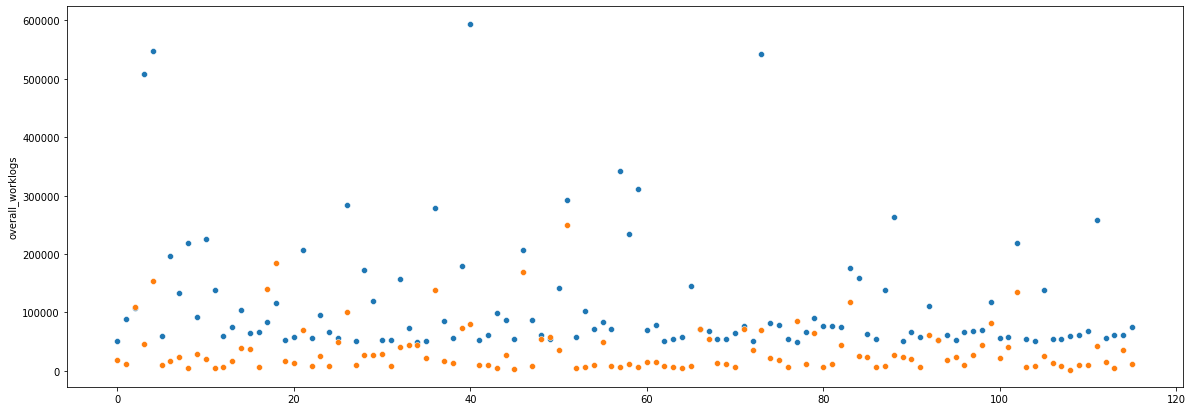

In [327]:
plt.figure(figsize=(20,7))
high_targ = res_val_df[res_val_df.overall_worklogs > 50000].reset_index(drop=True)
sns.scatterplot(x=high_targ.index, y='overall_worklogs', data=high_targ)
sns.scatterplot(x=high_targ.index, y='pred', data=high_targ)

In [338]:
pred = lgbm.predict(df_test)
pred = np.where(pred<0, 600, pred)
pred = np.exp(pred)

In [339]:
ind_df = pd.read_csv('data/solution_01.csv')
solution = pd.DataFrame({'overall_worklogs': pred}, index=ind_df.id)
solution.to_csv('data/solution_10.csv')

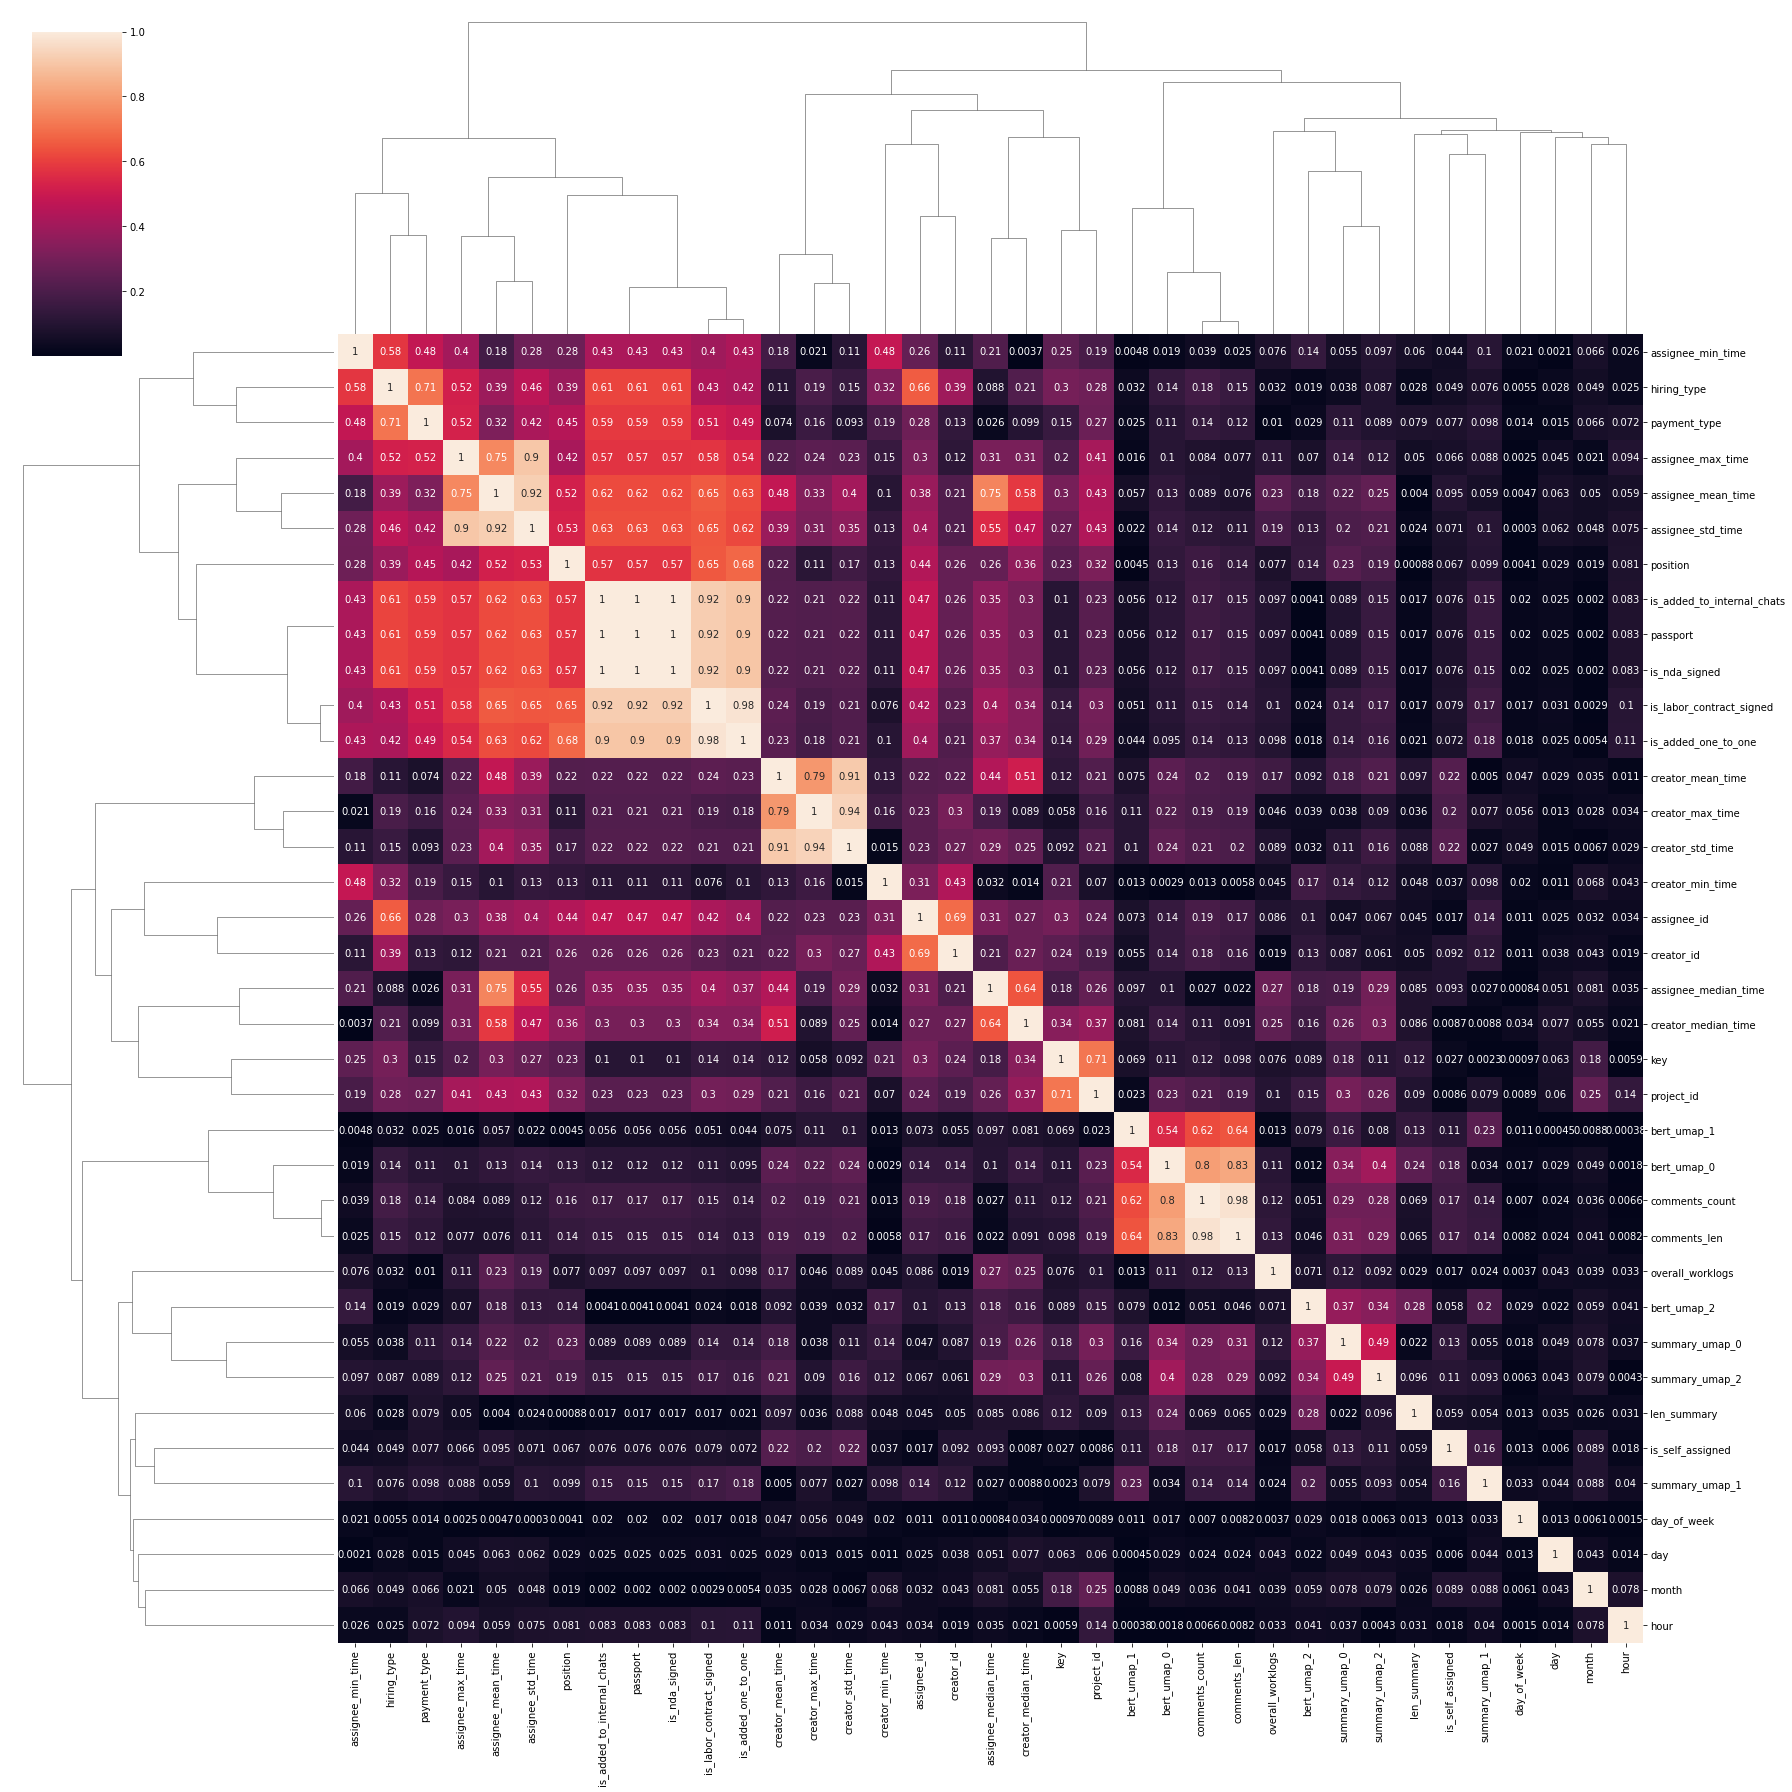

In [189]:
sns.clustermap(np.abs(df_train.corr('spearman')), figsize=(25, 25), annot=True)
plt.show()

In [617]:
com_df = pd.merge(df_issues_train, df_comment_train, left_on="id", right_on="issue_id", how='left')
com_df.text = com_df.text.fillna('')
all_comments = {}
for val in com_df[:50].id:
    all_text[val] = com_df[com_df.id == val].summary.iloc[0]
    all_text[val] += ' '.join([text for text in com_df[com_df.id == val].text.values])
    

In [ ]:
com_df[com_df.text.str.contains('later|tomorrow|завтра|потом')].overall_worklogs.median()

In [221]:
df_all_com.text = df_all_com.text.apply(lambda x: x.split(':')[-1] if x.__contains__('mentioned this issue in') else x)

In [220]:
test_df.loc[12553].text.split(':')[-1]

" fuzzy address'"

In [222]:
test_df = pd.merge(df_issues_train, df_comment_train, left_on="id", right_on="issue_id", how='left')

In [337]:
test_df[test_df.overall_worklogs >150000].sort_values('overall_worklogs').iloc[:50]

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,comment_id,text,issue_id,author_id
12439,682155,2020-11-03 19:37:02.000,FPY-901,Добавить расписание в прошивку,29,291,291,151200,NaN,NaN,NaN,NaN
13496,688599,2019-11-18 08:52:55.000,XXO-163,All Calls (Nov-3w),33,58,58,153000,NaN,NaN,NaN,NaN
12548,689140,2019-09-05 02:09:01.000,XXO-33,Web Customer account,33,1,58,153900,67734.0,Hope this is in the right place. \n\nCUSTOMER SIGNUP\n\n[https://www.figma.com/file/8mVhOBgf4pe4lKluclmTDD/sortedhouse?node-id=93%3A119]\n\n \n\nSign up Customer - Details\n\nUnder Mobile number field.\n\n“We use SMS to notify you with job related notifications you request from Sorted House pro...,689140.0,1.0
12552,689140,2019-09-05 02:09:01.000,XXO-33,Web Customer account,33,1,58,153900,70036.0,changes',689140.0,58.0
12553,689140,2019-09-05 02:09:01.000,XXO-33,Web Customer account,33,1,58,153900,70038.0,fuzzy address',689140.0,58.0
12554,689140,2019-09-05 02:09:01.000,XXO-33,Web Customer account,33,1,58,153900,70108.0,\n'SOR-33 fix avatar on provider info page',689140.0,58.0
12555,689140,2019-09-05 02:09:01.000,XXO-33,Web Customer account,33,1,58,153900,70124.0,prov acc - updated avatar styles',689140.0,58.0
12556,689140,2019-09-05 02:09:01.000,XXO-33,Web Customer account,33,1,58,153900,70126.0,prov acc - revert',689140.0,58.0
12557,689140,2019-09-05 02:09:01.000,XXO-33,Web Customer account,33,1,58,153900,70128.0,updated the styles of uploading avatar',689140.0,58.0
12558,689140,2019-09-05 02:09:01.000,XXO-33,Web Customer account,33,1,58,153900,70131.0,\n'SOR-33 fix avatar on provider info page',689140.0,58.0


In [205]:
mult_comms_time = test_df.groupby('created').agg({'id': 'count'})
mult_comms_time = mult_comms_time[mult_comms_time.id>1].index
mult_comms_time

Index(['2017-10-05 10:08:53.000', '2017-10-06 07:45:43.000',
       '2017-10-06 08:57:48.000', '2017-10-06 10:20:52.000',
       '2017-10-09 09:05:15.000', '2017-10-10 08:16:53.000',
       '2017-10-10 08:53:30.000', '2017-10-10 10:26:22.000',
       '2017-10-10 11:01:07.000', '2017-10-10 11:16:48.000',
       ...
       '2020-11-10 11:09:46.088', '2020-11-10 11:57:51.928',
       '2020-11-10 13:53:46.687', '2020-11-11 06:16:57.429',
       '2020-11-11 08:48:43.533', '2020-11-11 10:30:26.468',
       '2020-11-11 16:58:47.351', '2020-11-11 16:59:22.187',
       '2020-11-12 08:39:25.425', '2020-11-12 09:07:51.372'],
      dtype='object', name='created', length=2122)

In [206]:
test_df[test_df.created.isin(mult_comms_time)]

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,comment_id,text,issue_id,author_id
7,819933,2019-10-01 06:06:36.000,SM-10686,Сделать разделение по мобильным операторам,5,207,1,7800,65491.0,Добавил возможность отправлять требуемому оператору согласно префиксу номера. Коммит: [https://gitlab.com/TaxiNamba/taxi-sms-go/tree/NT-10686__Mob...,819933.0,1.0
8,819933,2019-10-01 06:06:36.000,SM-10686,Сделать разделение по мобильным операторам,5,207,1,7800,65966.0,Код в репо есть. Ссылка на коммит не ссылка на коммит. Задача выполнена,819933.0,207.0
11,819924,2019-10-01 08:36:09.000,SM-10690,Не отрабатывает cdr_calc_durations,5,264,207,17580,65494.0,[~mursidinovz] По поводу сентри почитай доку как настроить логирование ошибок для сентри там вроде как то по особенному настраивается,819924.0,1.0
12,819924,2019-10-01 08:36:09.000,SM-10690,Не отрабатывает cdr_calc_durations,5,264,207,17580,65511.0,"Ошибка оказалась не в коде, а в неправильных путях к задачам в селери. Ошибка была в том что они переместили задачу в другое место, но забыли поме...",819924.0,264.0
15,819917,2019-10-02 02:49:35.000,SM-10693,Собрать водительскую прилу с измененным id версии (0.4.29),5,8,54,5400,65530.0,"Для того, чтоб собрать билд APK для водителей, которые работают в других службах, \nнужно просто выбрать build variant prod_partners и собрать sig...",819917.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19555,670934,2020-06-02 10:08:14.000,LJ-1,Set up the neo4j by using a dataset from Slack,56,2,2,16200,75841.0,I learned how relations work in the cypher language. And I added relationships for:\r\n User->Channel (or Group)\r\n User->Message\r\n Message->C...,670934.0,2.0
19556,670934,2020-06-02 10:08:14.000,LJ-1,Set up the neo4j by using a dataset from Slack,56,2,2,16200,75842.0,I'm working on add replies to existing messages.,670934.0,2.0
19559,670930,2020-06-09 02:56:25.000,LJ-5,Expand a gitlab parser by adding members emails,56,2,2,5400,76101.0,I encountered a problem with access to `/users/:id/emails` endpoint. \r\n\r\nAs GitLab API documentation says I need to have an `admin` role but n...,670930.0,2.0
19560,670930,2020-06-09 02:56:25.000,LJ-5,Expand a gitlab parser by adding members emails,56,2,2,5400,76102.0,"I have learned that `users/:id/emails` endpoint available only for self-managed Gitlab instances. \r\nHowever, we already have users` emails accor...",670930.0,2.0


In [277]:
df_all.columns

Index(['key', 'project_id', 'assignee_id', 'creator_id', 'overall_worklogs',
       'day', 'month', 'hour', 'day_of_week', 'comments_count', 'comments_len',
       'position', 'hiring_type', 'payment_type', 'passport', 'is_nda_signed',
       'is_labor_contract_signed', 'is_added_to_internal_chats',
       'is_added_one_to_one', 'summary_umap_0', 'summary_umap_1',
       'summary_umap_2', 'summary_umap_3', 'summary_umap_4',
       'assignee_min_time', 'assignee_max_time', 'assignee_mean_time',
       'assignee_median_time', 'assignee_std_time', 'creator_min_time',
       'creator_max_time', 'creator_mean_time', 'creator_median_time',
       'creator_std_time', 'is_self_assigned', 'len_summary', 'bert_umap_0',
       'bert_umap_1', 'bert_umap_2', 'bert_umap_3', 'bert_umap_4'],
      dtype='object')

In [280]:
df_all.month = df_all['month'] = .created.dt.strftime('%m-%y')

6000.0      2340
5400.0      2062
7200.0      2017
8100.0       480
9000.0       436
6900.0       426
6600.0       362
2400.0       352
5700.0       326
17700.0      307
4500.0       268
7950.0       211
12600.0      209
13500.0      169
10800.0      103
6300.0        96
6750.0        70
18000.0       59
5100.0        56
11700.0       56
24180.0       53
10680.0       38
44220.0       19
9600.0        19
32400.0       19
28650.0       18
23400.0       15
15300.0       11
25200.0       11
7800.0         8
138600.0       8
10050.0        6
5850.0         5
18840.0        4
14100.0        3
4800.0         1
14400.0        1
Name: creator_median_time, dtype: int64

In [294]:
embeddings_df = df_all[['bert_umap_0',
       'bert_umap_1', 'bert_umap_2', 'bert_umap_3', 'bert_umap_4', 'summary_umap_0', 'summary_umap_1',
       'summary_umap_2', 'summary_umap_3', 'summary_umap_4']].copy()

In [295]:
embeddings_df.to_csv('data/embeddings-1.csv')